## Task 1

Repeat the process of selecting $\alpha$ in section 2.3 but using 2-step smoothing

Let's begin our script by importing necessary libraries. We then load the dataset.

In [5]:
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra
from sklearn.linear_model import LinearRegression # For Linear Regression

# Then read the data file into a DataFrame object
visitors = pd.read_csv('AustralianVisitors.csv')
visitors['Month']=pd.to_datetime(visitors['Month'])
visitors.set_index('Month', inplace=True)
visitors.head()

y = visitors['No of Visitors']

First, we define a function to calculate the Sum Squared Error (SSE) to measure the error.

In [6]:
def sse(x, y):
    return np.sum(np.power(x-y,2))

To calculate the optimal alpha for a 2-step ahead forecasting, we can shift smoothed series by two time units. This can be achieved by making error between the 3rd value in the original and the 1st in the smoothed, the 4th in original and the 2nd smoothed value and so on.

In [9]:
# Initialize an empty list to store SSE for each value of alpha
sse_two = []

# Define an array of values for alpha
alphas = np.arange(0.01,1,0.01)

# Loop through alphas
for i in alphas:
    smoothed = visitors.ewm(alpha = i, adjust=False).mean()
    sse_two.append(sse(smoothed[:-2], visitors.values[2:]))
    
    optimal_alpha_two = alphas[np.argmin(sse_two)]
print("Optimal Alpha for 2-step forecast {:.2f}".format(optimal_alpha_two))

Optimal Alpha for 2-step forecast 0.12


Then let's plot the SSE vs Alpha

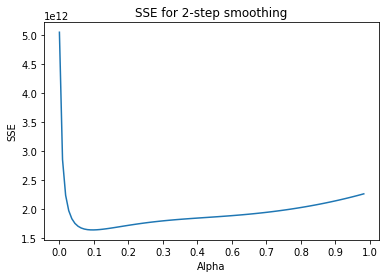

In [10]:
plt.figure()
plt.plot(sse_two)
plt.title("SSE for 2-step smoothing")
plt.ylabel("SSE")
plt.xlabel("Alpha")
plt.xticks(np.linspace(0, 100, 10), ["{0:1.1f}".format(x) for x in np.linspace(0,1,10)])
plt.show()

## Task 2

In the first task of Week 06 tutorial document, we have learnt how to select the best fitted $\alpha$ value for one-step forecasting. Now, continue with the Section 2 of week 06 tutorial, you need to find the best fitted $\alpha$ and $\beta$ value for the **AustralianVisitors.csv** dataset:
1. Load the dataset and implement a Holt's linear trend smoothing.
2. Define a range of $\alpha$ and $\beta$ value to iterate over to calculate the SSE.
3. Report the best fitted $\alpha$ and $\beta$ value and summarize your observation

We have done step 1 in the previous task. Now let's start from step 2. 

### 2. Define a range of  𝛼  and  𝛽  value to iterate over to calculate the SSE.

In [31]:
alphas = np.arange(0.01,1,0.02)  # Search for 50 values of alpha from 0.01 to 0.99  
betas = np.arange(0.01,1,0.02)   # Search for 50 values of alpha from 0.01 to 0.99

### 3. Report the best fitted  𝛼  and  𝛽  value and summarize your observation

We find the combination of ($\alpha, \beta$) minimizing the SSE of in-sample prediction error. We can simply re-use the manual code of TCES as shown in the tutorial and repeat the process within a nested for loop, one of $\alpha$ and one for $\beta$.

In [33]:
# Assign initial values for level and trend 
l0 = y[0]
b0 = y[1] - y[0]

# To store sse for each combination of (alpha,beta)
sse_one = np.zeros((len(alphas),len(betas)))

# Loop through all combination of (alpha,beta)
for k in range(len(alphas)):
    for j in range(len(betas)):
        
        # Pre-allocation (we can make an empty list here to speed up the computational time)
        # But to make it similar to the tutorial, we use the copy() method to pre-allocate variables
        y_forecast = y.copy().astype(float) 
        lt = y.copy().astype(float)
        bt = y.copy().astype(float)
    
        # Compute l[1], b[1] and Y_hat[2]
        lt[0] = alphas[k] * y[0] + (1 - alphas[k]) * (l0 + b0)
        bt[0] = betas[j] * (lt[0] - l0) + (1 - betas[j]) * b0
        y_forecast[1] = lt[0] + bt[0]

        # Create a loop to compute the forecast values using TCES
        for t in range(1,len(y)-1):
            # Compute level component
            lt[t] = alphas[k] * y[t] + (1 - alphas[k]) * (lt[t-1] + bt[t-1])
            
            # Compute trend component
            bt[t] = betas[j] * (lt[t] - lt[t-1]) + (1 - betas[j]) * bt[t-1]
            
            # Get the one-step-ahead forecast values
            y_forecast[t+1] = lt[t] + bt[t]
            
        sse_one[k,j] = sse(y_forecast[1:], y.values[1:])
        
# Get the index of the min sse
arg_min = np.unravel_index(sse_one.argmin(), sse_one.shape)

print('Optimal alpha: {:.2f}'.format(alphas[arg_min[0]]))
print('Optimal beta : {:.2f}'.format(betas[arg_min[1]]))

Optimal alpha: 0.13
Optimal beta : 0.07


This is another way to implement the grid search for $\alpha$ bad $\beta$

In [34]:
sse_one = np.zeros((len(alphas),len(betas)))
l0 = y[0]
b0 = y[1] - y[0]
# Loop through all combination of (alpha,beta)
for k in range(len(alphas)):
    # Empty list to store the in-sample forecast
    holts_linear = []
    for j in range(len(betas)):
        l = [l0]
        b = [b0]
        # Empty list to store the in-sample forecast
        holts_linear = []
        for i in range(len(y)):
            l.append(alphas[k] * y[i] + (1 - alphas[k]) * (l[i] + b[i])) # Calculate level lt
            b.append(betas[j] * (l[i+1] - l[i]) + (1 - betas[j]) * b[i]) # Calculate trend bt
            holts_linear.append(l[i+1] + b[i+1])  # Append it to the list
        sse_one[k,j] = sse(holts_linear[:-1], y.values[1:])
        
# Get the index of the min sse
arg_min = np.unravel_index(sse_one.argmin(), sse_one.shape)

print('Optimal alpha: {:.2f}'.format(alphas[arg_min[0]]))
print('Optimal beta : {:.2f}'.format(betas[arg_min[1]]))

Optimal alpha: 0.13
Optimal beta : 0.07
